In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import re
import plotly
plt.style.use('ggplot')

In [437]:
majestic_df = pd.read_csv('majestic6.csv', header=None)
next_df = pd.read_csv('majestic7.csv', header=None)
next2 = pd.read_csv('majestic10.csv', header=None)
next3 = pd.read_csv('majestic11.csv', header=None)
next4 = pd.read_csv('majestic12.csv', header=None)

In [438]:
# concatenating scraped csvs
majestic_df = pd.concat([majestic_df, next_df, next2, next3, next4], ignore_index=True)

In [439]:
#renaming columns
majestic_df.columns = ['Name', 'Percentage of reviewers who would buy again',
                       'Number of Reviewers', 'Awards', 'Volume', 'ABV',
                       'Short Description', 'Long Description', 'Per Bottle Price',
                       'Mix Six Price', 'Type', 'Style', 'Closure', 'Units', 'Grape', 'Country']
# reordering
columnTitles=['Name', 'Country', 'Type', 'Style', 'Grape',
              'Short Description', 'Long Description',
              'Per Bottle Price', 'Mix Six Price',
              'Percentage of reviewers who would buy again',
              'Number of Reviewers', 'Awards', 'Closure',
              'ABV', 'Units', 'Volume']

majestic_df=majestic_df.reindex(columns=columnTitles)

In [440]:
majestic_df.shape

(808, 16)

In [441]:
# dropping duplicates
majestic_df.drop_duplicates(subset=None, keep='first', inplace=True)
majestic_df.shape

(790, 16)

In [442]:
### Data Cleaning

In [443]:
majestic_df[majestic_df['Mix Six Price'] == 'Red'] = 0
majestic_df[majestic_df['Mix Six Price'] == 'White'] = 0
majestic_df['Mix Six Price'] = majestic_df['Mix Six Price'].fillna(0)
majestic_df['Mix Six Price'] = pd.to_numeric(majestic_df['Mix Six Price'])
majestic_df[majestic_df['Mix Six Price'] == 0] = np.nan

In [444]:
majestic_df['Number of Reviewers'] = majestic_df['Number of Reviewers'].fillna(0)
majestic_df['Number of Reviewers'] = majestic_df['Number of Reviewers'].astype(str)
majestic_df['Number of Reviewers'] = majestic_df['Number of Reviewers'].str.replace(',', '').astype(float) 
majestic_df[majestic_df['Number of Reviewers'] == 0] = np.nan


In [445]:
majestic_df['Savings'] = majestic_df['Per Bottle Price']-majestic_df['Mix Six Price']
majestic_df['Percent Saved'] = round(majestic_df['Savings']/majestic_df['Per Bottle Price']*100, 0)
majestic_df['price_for_75cl'] = (majestic_df['Per Bottle Price']/majestic_df['Volume'])*75

In [446]:
majestic_df[majestic_df['Short Description'] == 'CHILE'] = np.nan
majestic_df[majestic_df['Short Description'] == 'NEW ZEALAND'] = np.nan

In [447]:
majestic_df.Awards.replace(np.nan, '[]', inplace=True)

In [448]:
majestic_df.Awards = majestic_df.Awards.apply(lambda x: x[1:-1])

In [449]:
majestic_df['Number_of_Awards'] = majestic_df.Awards.apply(lambda x: len(x))
majestic_df.Awards = majestic_df.Awards.apply(lambda x: x.split(', '))

In [450]:
award_df = pd.DataFrame(majestic_df[majestic_df.Number_of_Awards > 0].Awards.apply(lambda x: len(x)))
award_df.columns = ['Number of Awards']
majestic_df = pd.merge(majestic_df, award_df, how='left', left_index=True, right_index=True)
majestic_df['Number of Awards'] = majestic_df['Number of Awards'].fillna(0)
majestic_df['Number of Awards'] = majestic_df['Number of Awards'].apply(lambda x: int(x))
majestic_df = majestic_df.drop('Number_of_Awards', axis = 1)

In [451]:
majestic_df.Grape.isna().sum()/majestic_df.shape[0]

0.7367088607594937

In [452]:
majestic_df.Grape = majestic_df.Grape.fillna('?')
majestic_df.Grape = majestic_df.Grape.apply(lambda x: x.split(', '))

In [453]:
df_grape = majestic_df.copy()
# i keeps tracks of index
index=0
# save [index, genre] in a nested list
list_ = []
for item in df_grape.Grape:
    list_.extend(map(lambda x: [index, x], item))
    index += 1
grapes = pd.DataFrame(list_, columns=['index', 'grapes'])

In [454]:
df_grape = pd.merge(df_grape.drop('Grape', axis=1), grapes, how='right', left_index=True, right_on='index')
top_grapes_df = df_grape.groupby('grapes').filter(lambda x: x.shape[0] > 8 and x.shape[0] < 200)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

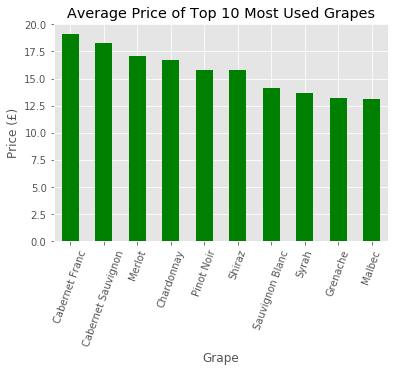

In [455]:
top_grapes_df.groupby('grapes')['Per Bottle Price'].mean().sort_values(ascending=False)[0:10].plot.bar(color='g')
plt.title('Average Price of Top 10 Most Used Grapes')
plt.ylabel('Price (£)')
plt.xlabel('Grape')
plt.xticks(rotation=70)

Text(0, 0.5, 'Price (£)')

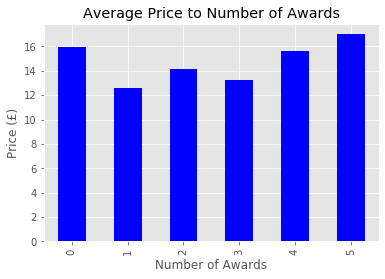

In [456]:
majestic_df.groupby('Number of Awards')['Per Bottle Price'].mean().plot.bar(color='b')
plt.title('Average Price to Number of Awards')
plt.ylabel('Price (£)')

Text(0, 0.5, 'Number of Bottles')

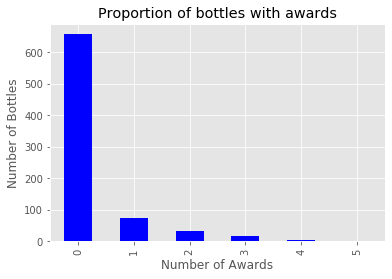

In [457]:
majestic_df.groupby('Number of Awards')['Number of Awards'].count().plot.bar(color='b')
plt.title('Proportion of bottles with awards')
plt.ylabel('Number of Bottles')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

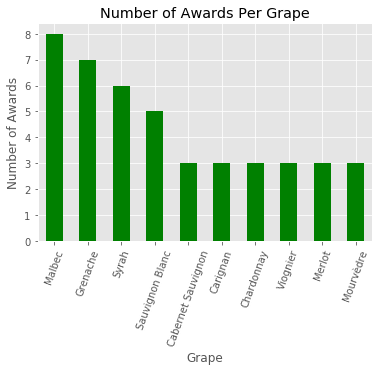

In [477]:
df_grape[df_grape['Number of Awards']>0].groupby('grapes')['grapes'].count().sort_values(ascending=False)[1:11].plot.bar(color='g')
plt.title('Number of Awards Per Grape')
plt.ylabel('Number of Awards')
plt.xlabel('Grape')
plt.xticks(rotation=70)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

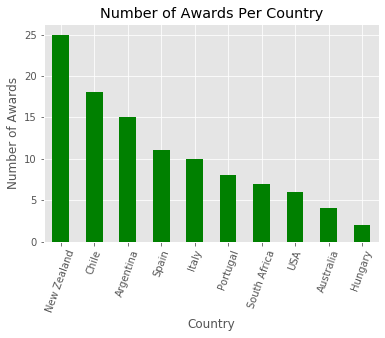

In [473]:
df_grape[df_grape['Number of Awards']>0].groupby('Country')['Country'].count().sort_values(ascending=False)[1:11].plot.bar(color='g')
plt.title('Number of Awards Per Country')
plt.ylabel('Number of Awards')
plt.xlabel('Country')
plt.xticks(rotation=70)

Text(0, 0.5, 'Grape')

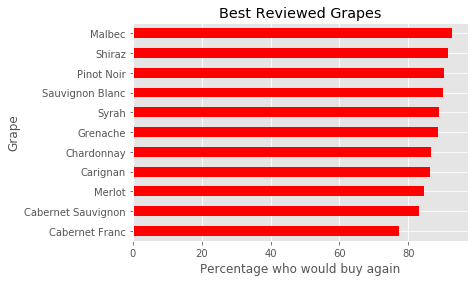

In [483]:
top_grapes_df.groupby('grapes')['Percentage of reviewers who would buy again'].mean().sort_values(ascending=True).plot.barh(color='r')
plt.title('Best Reviewed Grapes')
plt.xlabel('Percentage who would buy again')
plt.ylabel('Grape')

Text(0.5, 1.0, 'Country by Average Price')

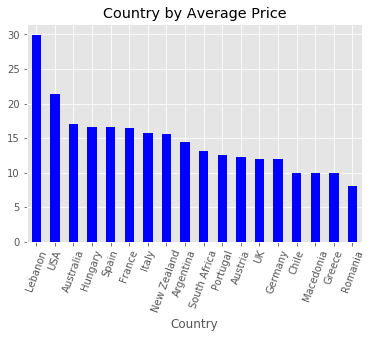

In [76]:
majestic_df.groupby('Country')['Per Bottle Price'].mean().sort_values(ascending=False).plot.bar(color='b')
plt.xticks(rotation=70)
plt.title('Country by Average Price')

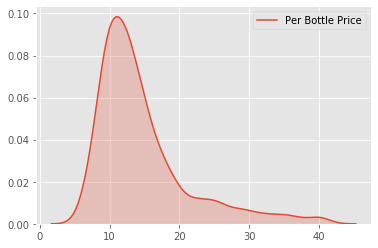

In [77]:
outliers = majestic_df[['Per Bottle Price']]
outliers = outliers.loc[outliers.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]
sns.kdeplot(outliers['Per Bottle Price'], shade=True)

Text(0.5, 1.0, 'Price by Wine Type')

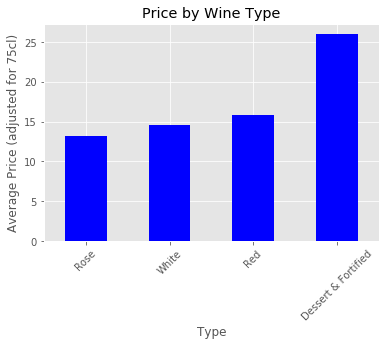

In [78]:
majestic_df.groupby('Type')['price_for_75cl'].mean().sort_values(ascending=True).plot.bar(color = 'b')
plt.ylabel('Average Price (adjusted for 75cl)')
plt.xticks(rotation=45)
plt.title('Price by Wine Type')

Text(0.5, 1.0, 'Price Distribution for Red and White Wine')

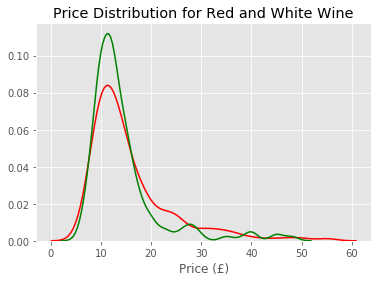

In [79]:
type_red = majestic_df[majestic_df['Type']=='Red']
type_white = majestic_df[majestic_df['Type']=='White']

type_red_cut = type_red[type_red['Per Bottle Price']<60]
type_white_cut = type_white[type_white['Per Bottle Price']<60]

sns.distplot(type_red_cut[['Per Bottle Price']], hist=False, color='r')
sns.distplot(type_white_cut[['Per Bottle Price']], hist=False, color='g')
plt.xlabel('Price (£)')
plt.title('Price Distribution for Red and White Wine')

Text(0.5, 1.0, 'Histogram for Number of Reviews')

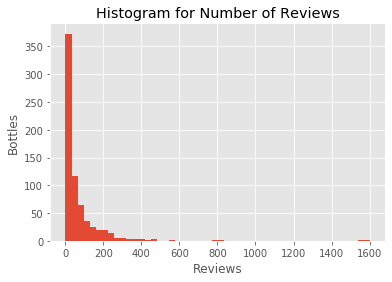

In [80]:
### Masses never reveiwed

plt.hist(majestic_df['Number of Reviewers'], bins=50)
plt.xlabel('Reviews')
plt.ylabel('Bottles')
plt.title('Histogram for Number of Reviews')

In [81]:
reviewer_subset = majestic_df[majestic_df['Number of Reviewers']>20]
import plotly.express as px
fig = px.scatter(reviewer_subset, x=reviewer_subset['Number of Reviewers'], y=reviewer_subset['Percentage of reviewers who would buy again'], hover_name=reviewer_subset['Name'])
fig.show()

Text(0.5, 1.0, 'Red Prices by Description')

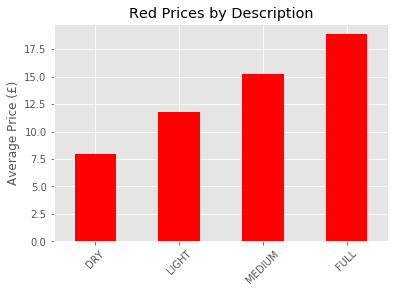

In [84]:
### Price averages for Red Wine

majestic_df[majestic_df['Type']=='Red'].groupby('Short Description')['Per Bottle Price'].mean().sort_values(ascending=True).plot.bar(color='r')
plt.ylabel('Average Price (£)')
plt.xlabel('')
plt.xticks(rotation=45)
plt.title('Red Prices by Description')

Text(0.5, 1.0, 'Red Prices by Style')

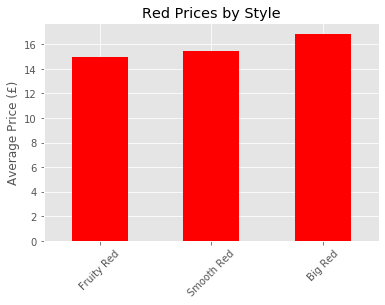

In [85]:
majestic_df[majestic_df['Type']=='Red'].groupby('Style')['Per Bottle Price'].mean().sort_values(ascending=True).plot.bar(color='r')
plt.xlabel('')
plt.ylabel('Average Price (£)')
plt.xticks(rotation=45)
plt.title('Red Prices by Style')

Text(0, 0.5, '% who would buy again')

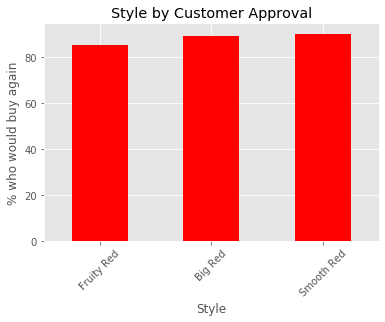

In [86]:
reviewer_subset[reviewer_subset['Type']=='Red'].groupby('Style')['Percentage of reviewers who would buy again'].mean().sort_values(ascending=True).plot.bar(color='r')
plt.title('Style by Customer Approval')
plt.xticks(rotation=45)
plt.ylabel('% who would buy again')

Text(0.5, 1.0, 'White Prices by Description')

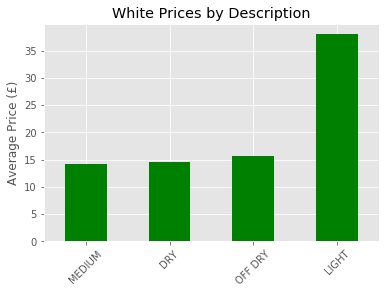

In [87]:
### Price avgs for White
majestic_df[majestic_df['Type']=='White'].groupby('Short Description')['Per Bottle Price'].mean().sort_values(ascending=True).plot.bar(color='g')
plt.ylabel('Average Price (£)')
plt.xlabel('')
plt.xticks(rotation=45)
plt.title('White Prices by Description')

Text(0.5, 1.0, 'White Prices by Style')

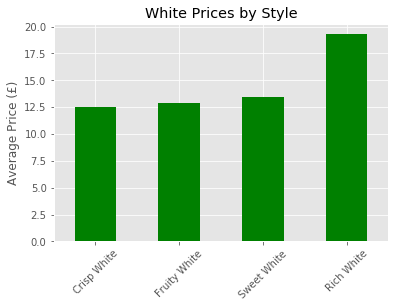

In [88]:
majestic_df[majestic_df['Type']=='White'].groupby('Style')['Per Bottle Price'].mean().sort_values(ascending=True).plot.bar(color='g')
plt.xlabel('')
plt.ylabel('Average Price (£)')
plt.xticks(rotation=45)
plt.title('White Prices by Style')

Text(0, 0.5, '% who would buy again')

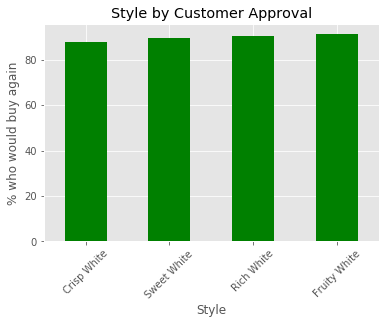

In [89]:
reviewer_subset[reviewer_subset['Type']=='White'].groupby('Style')['Percentage of reviewers who would buy again'].mean().sort_values(ascending=True).plot.bar(color='g')
plt.title('Style by Customer Approval')
plt.xticks(rotation=45)
plt.ylabel('% who would buy again')

Text(0.5, 1.0, 'Cork Premium')

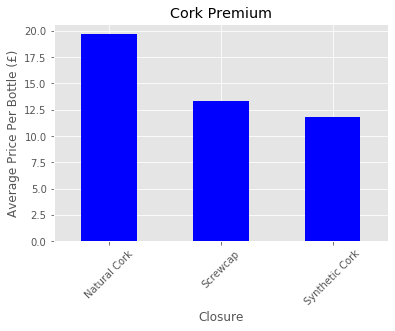

In [90]:
majestic_df.groupby('Closure')['price_for_75cl'].mean().sort_values(ascending=False).plot.bar(color='b')
plt.ylabel('Average Price Per Bottle (£)')
plt.xticks(rotation = 45)
plt.title('Cork Premium')